# TEST & XAI
Ce programme permet de tester les modèles avec des techniques d'IA explicable (XAI) :

1. Nous allons visualiser les 5 dernières couches d'attention du modèle,    
   afin d'identifier les tokens importants dans la prediction de 4 phrases d'exemple.
2. Nous allons analyser les tokens avec un bon système visuel.

Model: "tf_bert_for_token_classification_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177262848 
                                                                 
 dropout_417 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  9997      
                                                                 
Total params: 177272845 (676.24 MB)
Trainable params: 177272845 (676.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model summary: None

/////////////////////////////////////////////////////////////////////////////////////////////////

---   Phrase : 
---> 'Je me demandais si...'


Ici on voit sur quels tokens d'entrées bert-base-multilingual-cased porte son atte

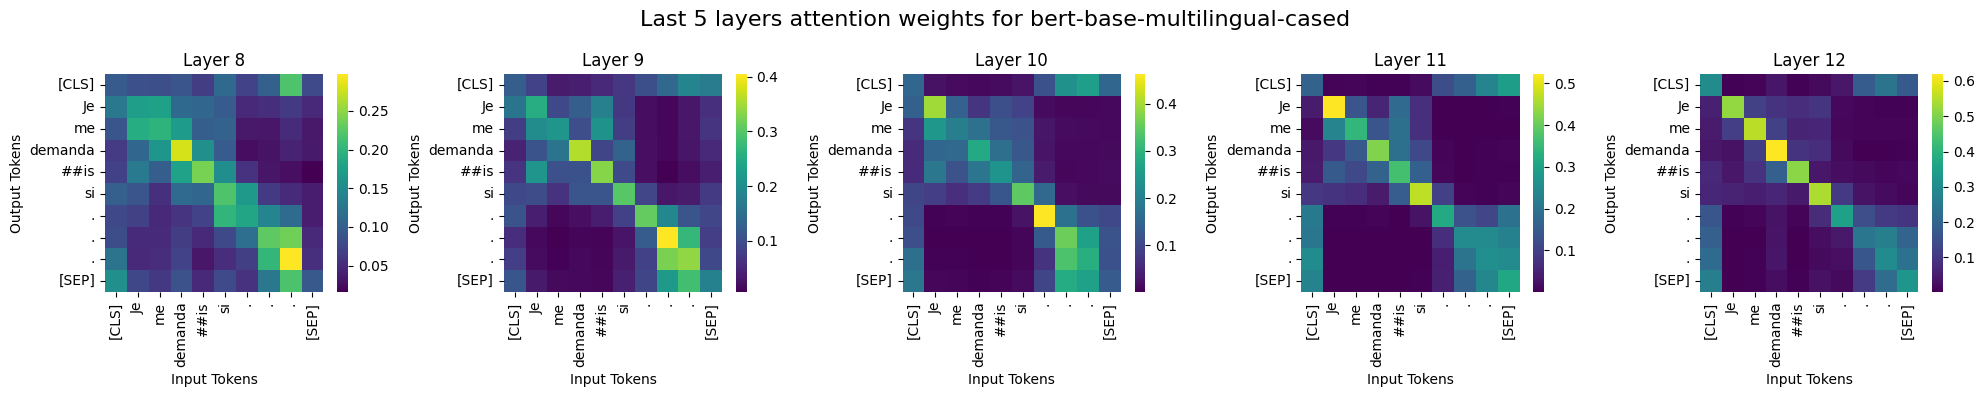

Nombre total de layers: 12

/////////////////////////////////////////////////////////////////////////////////////////////////

---   Phrase : 
---> 'Mais en fait, je ne veux veux pas y aller.'


Ici on voit sur quels tokens d'entrées bert-base-multilingual-cased porte son attention pour chaque token de sortie. Pour produire son embedding.


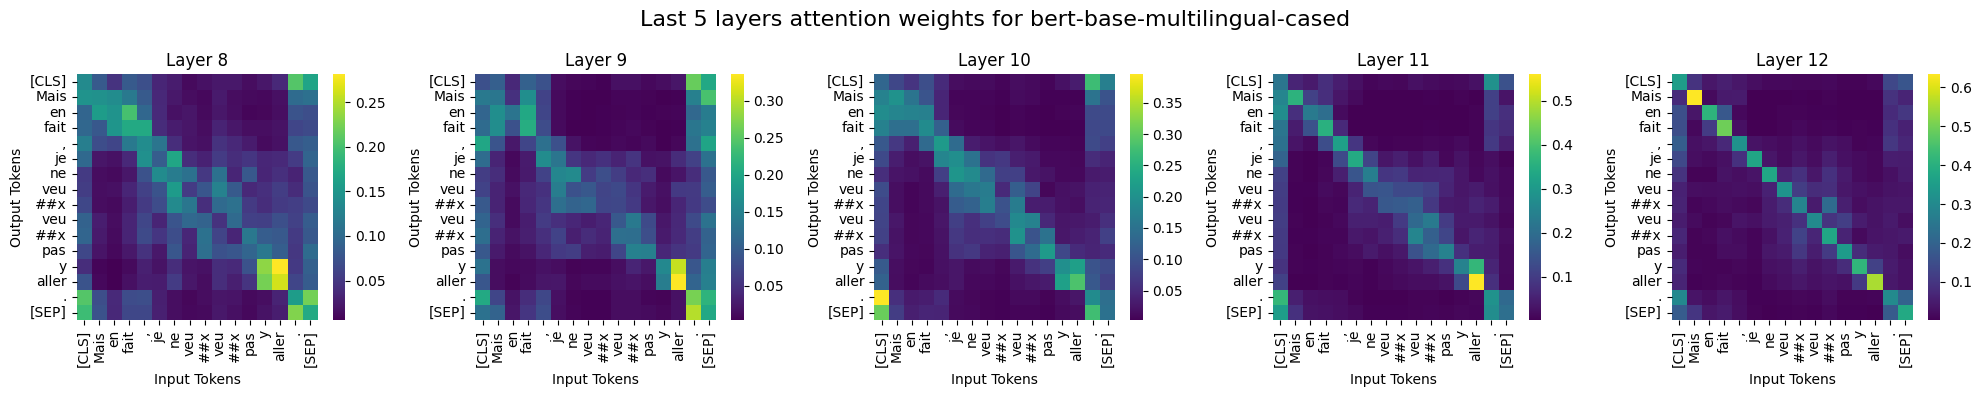

Nombre total de layers: 12

/////////////////////////////////////////////////////////////////////////////////////////////////

---   Phrase : 
---> 'Euh, [Bruit] mais enfin, que se passe-t-il exactement ?'


Ici on voit sur quels tokens d'entrées bert-base-multilingual-cased porte son attention pour chaque token de sortie. Pour produire son embedding.


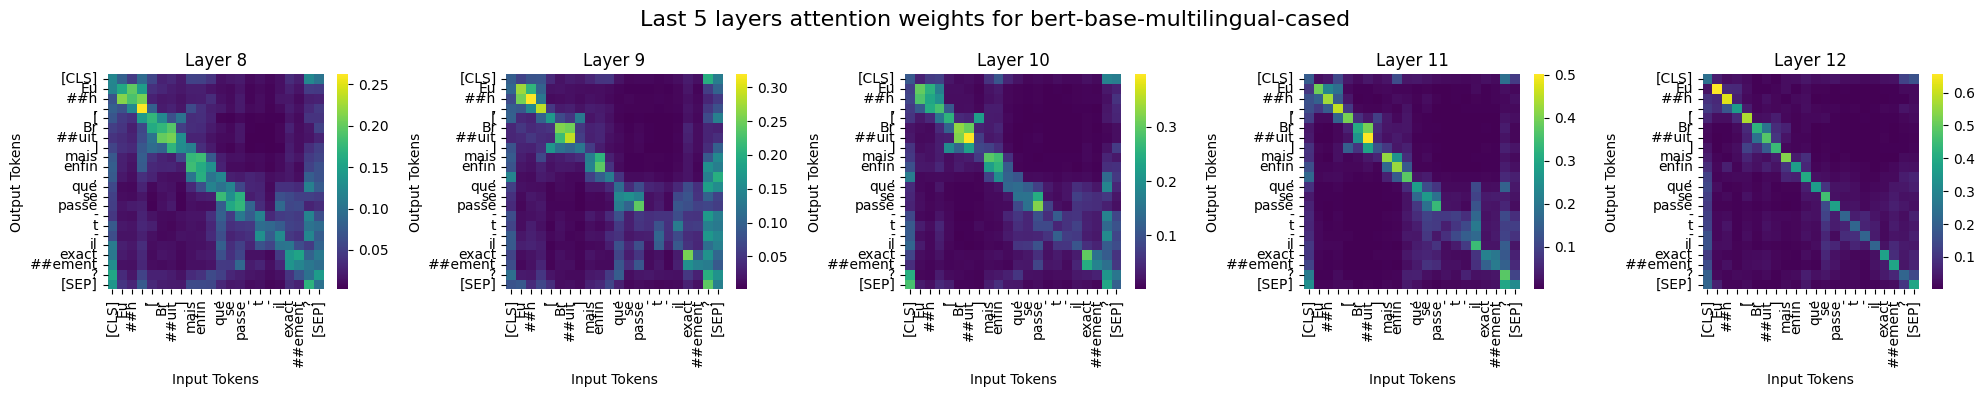

Nombre total de layers: 12

/////////////////////////////////////////////////////////////////////////////////////////////////

---   Phrase : 
---> 'Ah, je ne ne ne vois plus rien !'


Ici on voit sur quels tokens d'entrées bert-base-multilingual-cased porte son attention pour chaque token de sortie. Pour produire son embedding.


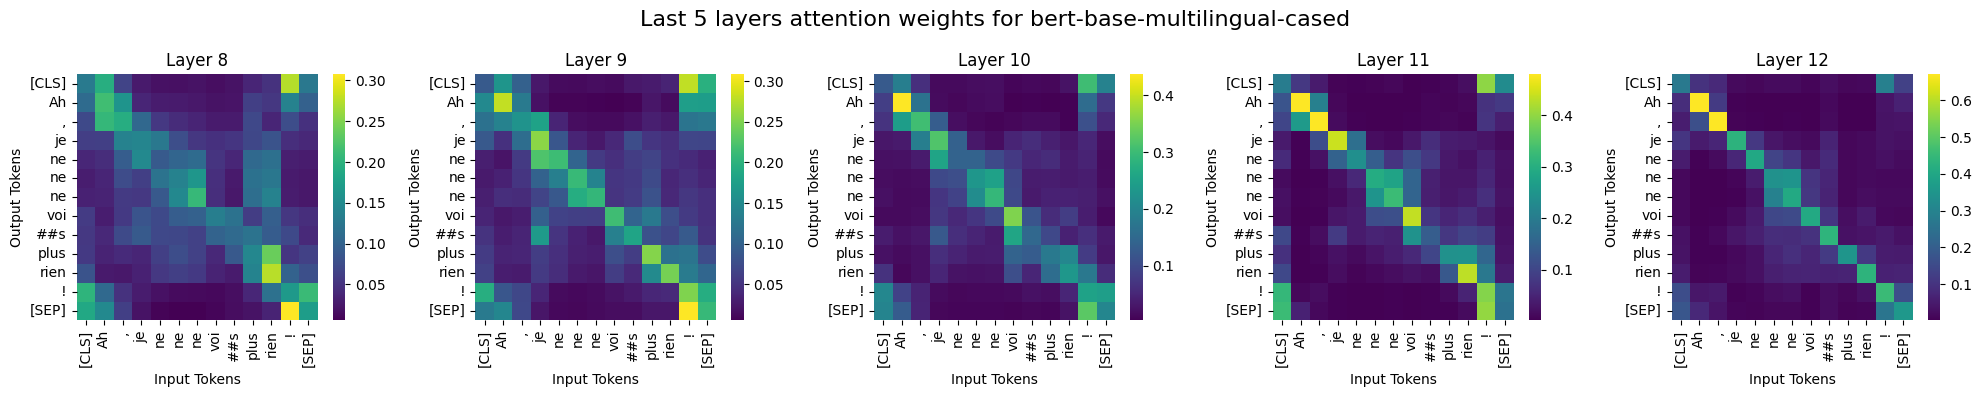

Nombre total de layers: 12

/////////////////////////////////////////////////////////////////////////////////////////////////

---   Phrase : 
---> ' euh... hum je ne sais trop quoi dire'


Ici on voit sur quels tokens d'entrées bert-base-multilingual-cased porte son attention pour chaque token de sortie. Pour produire son embedding.


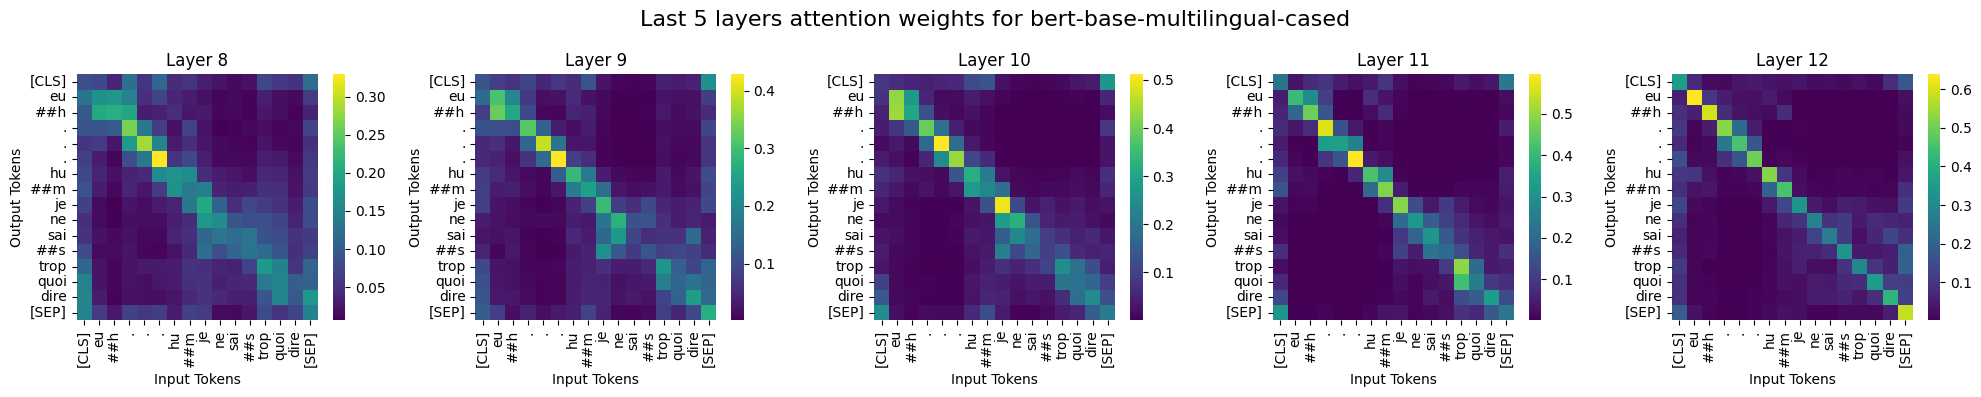

Nombre total de layers: 12


In [12]:
import os
from transformers import logging as hf_logging
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
hf_logging.set_verbosity_error()

from transformers import BertTokenizerFast, TFBertForTokenClassification
from utils_xai_ner import visualize_attention


phrases = [
    "Je me demandais si...",
    "Mais en fait, je ne veux veux pas y aller.",
    "Euh, [Bruit] mais enfin, que se passe-t-il exactement ?",
    "Ah, je ne ne ne vois plus rien !",
    " euh... hum je ne sais trop quoi dire",
]

model_name = "bert-base-multilingual-cased"
base_dir = os.getcwd()
model_path = os.path.join(base_dir, '..', 'API', 'models', model_name)

tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = TFBertForTokenClassification.from_pretrained(model_path)

print("Model summary:", model.summary())

for idx, phrase in enumerate(phrases, 1):
    visualize_attention(phrase, model, tokenizer, model_name)


### Évolution de la répartition des poids à travers les couches

Dans les graphiques ci-dessus,   
_Output tokens_ = le token que le modèle est en train d'analyser       
_Input tokens_ = l'ensemble des tokens disponibles en entrée sur lesquels le modèle peut "porter son attention"      

- Les tokens regardent plusieurs autres tokens pour contextualiser leur sens
- Certains tokens se focalisent davantage sur un petit nombre de tokens
- Le modèle affine progressivement la représentation des mots, des liaisons, du sens
- L'embeding est enfin stabilisé avec des mots "autofocusé" pour la tâche de classification

In [13]:
import os
import time
from transformers import logging as hf_logging
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
hf_logging.set_verbosity_error()

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from utils_xai_ner import print_predict_duration
from utils_ner import encode_data
from transformers import BertTokenizerFast, TFBertForTokenClassification, AutoConfig


test_phrases = [
    {
        "Phrase": "Je me demandais si...",
        "items": "['Je', 'me', 'demandais', 'si', '.', '.', '.']",
        "labels": "['O', 'O', 'O', 'O', 'B-SIL', 'I-SIL', 'I-SIL']"
    },
    {
        "Phrase": "Mais en fait, je ne veux veux pas y aller.",
        "items": "['Mais', 'en', 'fait', ',', 'je', 'ne', 'veux', 'veux', 'pas', 'y', 'aller', '.']",
        "labels": "['B-FIL', 'I-FIL', 'I-FIL', 'O', 'O', 'O', 'O', 'B-REP', 'O', 'O', 'O', 'O']"
    },
    {
        "Phrase": "Euh, [Bruit] mais enfin, que se passe-t-il exactement ?",
        "items": "['Euh', ',', '[Bruit]', 'mais', 'enfin', ',', 'que', 'se', 'passe-t-il', 'exactement', '?']",
        "labels": "['B-FIL', 'O', 'B-NOI', 'B-INT', 'I-INT', 'O', 'O', 'O', 'O', 'O', 'O']"
    },
    {
        "Phrase": "Ah, je ne ne ne vois plus rien !",
        "items": "['Ah', ',', 'je', 'ne', 'ne', 'ne', 'vois', 'plus', 'rien', '!']",
        "labels": "['B-INT', 'O', 'O', 'O', 'B-REP', 'I-REP', 'O', 'O', 'O', 'O']"
    },
    {
        "Phrase": " euh... hum je ne sais trop quoi dire",
        "items": "['euh', '.', '.', '.', 'hum', 'je', 'ne', 'sais', 'trop', 'quoi', 'dire']",
        "labels": "['B-FIL', 'B-SIL', 'I-SIL', 'I-SIL', 'B-FIL', 'O', 'O', 'O', 'O', 'O', 'O']"
    }
]


# Access model
model_name = "bert-base-multilingual-cased"
base_dir = os.getcwd()
model_path = os.path.join(base_dir, '..', 'API', 'models', model_name)

tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = TFBertForTokenClassification.from_pretrained(model_path)

# Encode data with corresponding labels
unique_labels = ['O', 'B-STU', 'I-STU', 'B-FIL', 'I-FIL', 'B-REP', 'I-REP', 'B-INT', 'I-INT', 'B-NOI', 'I-NOI', 'B-SIL', 'I-SIL']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

tokenizers = {}
loaded_models = {}



# Process "test phrase"
for test_phrase in test_phrases:
    start_time = time.time()
    phrase_data = pd.DataFrame([test_phrase])
    encoded_tokens, encoded_labels = encode_data(phrase_data, tokenizer, label_encoder)
    predictions = model.predict(encoded_tokens).logits
    predicted_labels = np.argmax(predictions, axis=-1)

    predicted_label_names = [label_encoder.inverse_transform([label_id])[0] for label_id in predicted_labels[0]]
    true_labels = [label_encoder.inverse_transform([label_id])[0] for label_id in encoded_labels[0]]

    prediction_success = predicted_label_names == true_labels
    print(f"\n// Prediction success for '{test_phrase['Phrase']}':", prediction_success)

    tokens_with_special_tokens = tokenizer.convert_ids_to_tokens(encoded_tokens[0])

    print("\nResult:")
    print("{:<14} {:<10} {:<8} {:<6}".format("Token", "Predicted", "True", "Result"))
    print("-" * 42)

    for token, predicted_label, true_label in zip(tokens_with_special_tokens, predicted_label_names, true_labels):
        if token == "[PAD]":
            continue
        result = "✔️" if predicted_label == true_label else "❌"
        print("{:<14} {:<10} {:<8} {:<6}".format(token, predicted_label, true_label, result))

    end_time = time.time()
    print_predict_duration(start_time, end_time)


---> Ligne 1
- Original items:  ['Je', 'me', 'demandais', 'si', '.', '.', '.']
- Tokens after encodage:  ['[CLS]', 'Je', 'me', 'demanda', '##is', 'si', '.', '.', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
- Labels after encodage:  ['O' 'O' 'O' 'O' 'O' 'O' 'B-SIL' 'I-SIL' 'I-SIL' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O']

// Encoding completed //

1/1 [==============================] - 4s 4s/step

// Prediction success for 'Je me demandais si...': True

Result:
Token          Predicted  True     Result
------------------------------------------
[CLS]          O          O        ✔️    
Je             O          O        ✔️    
me             O          O        ✔️    
demanda        O          O        ✔️    
##is   

### Conclusion
Le modèle bert-base-multilingual-cased entrainé pour reconnaitre les entités _STU, FIL, REP, INT, NOI, SIL_, pour la fonctionnalité de derushage fonctionne plutôt bien.   
Cependant, certaine erreur de predictions se produisent sur les I-REP, un peu moins représenté dans le dataset, car pour pouvoir avoir un I-REP il faut qu'un' mot soit prononcé 3 x